# N-grams Pattern-mining in Menus

**Speech in Context Lab — UBC Department of Linguistics**

---

### Project Overview

This project explores patterns of **codeswitching** in bilingual menus, with a focus on how Chinese and Western restaurants use language to present food items.

We:
* Collected menus from both **Chinese** and **Western** restaurant websites
* Extracted dish names in both **Chinese** and **English**
* Compiled and cleaned the data into a structured corpus
* Built keyword search functions to quantify mentions of target items (e.g., “burger”, “milk tea”) across restaurant types
* Laid groundwork for further **linguistic analysis** of lexical borrowing, cultural framing, and semantic domains


**Team Members:**
- Minh Nguyen
- Spencer Liao
- Desmond Bai

**Project Leads:**
- Molly Babel
- Chenxi Xu

---

In [1]:
# required libraries
import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import spacy
import pandas as pd
import re

ModuleNotFoundError: No module named 'wordcloud'

In [2]:
# read data from file
FILE_PATH = "./data/restaurant_raw_data.tsv" # please change it to match where you store the data

vocab_df = pd.read_csv(FILE_PATH, sep="\t")

#remove rows with blank values in dish names
vocab_df = vocab_df.dropna(subset='word_dish')
vocab_df['ch_counterpart_if_any'].fillna("", inplace=True)
# vocab_df.head()

In [3]:
# get some basic information like number of rows, how many restaurants, etc
vocab_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1384 entries, 0 to 1384
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   word_dish              1384 non-null   object
 1   lang_en_ch             1384 non-null   object
 2   ch_counterpart_if_any  1384 non-null   object
 3   restaurant_name        1384 non-null   object
 4   restaurant_type_en_ch  1384 non-null   object
 5   website_url            1384 non-null   object
dtypes: object(6)
memory usage: 75.7+ KB


In [4]:
vocab_df.describe()

,word_dish,lang_en_ch,ch_counterpart_if_any,restaurant_name,restaurant_type_en_ch,website_url
count,1384,1384,1384,1384,1384,1384
unique,1339,2,143,34,2,34
top,Chili,en,,Seaport City Restaurant,ch,https://swypepos.com/olo/en/seaportcity/001?t=...
freq,3,1335,1242,179,792,179


In [5]:
vocab_df['restaurant_type_en_ch'].value_counts()

restaurant_type_en_ch
ch    792
en    592
Name: count, dtype: int64

We have about 416 rows for Chinese restaurants, and 93 rows for Western restaurant for the moment

In [6]:
print("Number of unique restaurants =", len(vocab_df['restaurant_name'].unique()))
print("Restaurant list =\n", vocab_df['restaurant_name'].unique())

Number of unique restaurants = 34
Restaurant list =
 ['Lin Chinese Cuisine And Tea House' 'Broadway Chinese Restaurant'
 'Seaport City Seafood Restaurant' 'Peaceful Restaurant' 'Chinatown BBQ'
 'Happy Noodle House' 'Seaport City Restaurant' 'Peaceful Express'
 'New Sun Restaurant' 'Jingle Bao' 'Sun Sui Wah' 'Jollibee'
 'Bin 4 Burger Lounge' 'The Ellis' 'Fable Kitchen' 'Nook'
 'Casereccio Foods' 'Novo Italian' 'Giardino' "Dave & Mel's Pizzeria"
 'Beach Ave Bar And Grill' 'Burger Crush' 'España Restaurant' 'Alibi Room'
 'Chambar' 'Meat & Bread' 'Super Smash Burgers' 'JOEY Burrard' 'Lupo'
 'The Flying Pig' 'Ask For Luigi' 'Osteria Savio Volpe'
 'Tap & Barrel - Bridges' 'Robba Da Matti']


In [7]:
western_restaurants = vocab_df.query("restaurant_type_en_ch == 'en'")["restaurant_name"].unique()
print("Number of unique Western restaurants = ", len(western_restaurants))
print("Names =\n", western_restaurants)

Number of unique Western restaurants =  23
Names =
 ['Jollibee' 'Bin 4 Burger Lounge' 'The Ellis' 'Fable Kitchen' 'Nook'
 'Casereccio Foods' 'Novo Italian' 'Giardino' "Dave & Mel's Pizzeria"
 'Beach Ave Bar And Grill' 'Burger Crush' 'España Restaurant' 'Alibi Room'
 'Chambar' 'Meat & Bread' 'Super Smash Burgers' 'JOEY Burrard' 'Lupo'
 'The Flying Pig' 'Ask For Luigi' 'Osteria Savio Volpe'
 'Tap & Barrel - Bridges' 'Robba Da Matti']


In [8]:
western_restaurants = vocab_df.query("restaurant_type_en_ch == 'ch'")["restaurant_name"].unique()
print("Number of unique Chinese restaurants = ", len(western_restaurants))
print("Names =\n", western_restaurants)

Number of unique Chinese restaurants =  11
Names =
 ['Lin Chinese Cuisine And Tea House' 'Broadway Chinese Restaurant'
 'Seaport City Seafood Restaurant' 'Peaceful Restaurant' 'Chinatown BBQ'
 'Happy Noodle House' 'Seaport City Restaurant' 'Peaceful Express'
 'New Sun Restaurant' 'Jingle Bao' 'Sun Sui Wah']


### Data cleaning and pre-processing
We can convert the dish names into lower cases, to search more easily

In [9]:
# initialize Spacy for tokenization
# !python -m spacy download zh_core_web_sm # install zh_core_web_sm for Chinese tokenization
spacy_nlp_en = spacy.load("en_core_web_sm")
spacy_nlp_ch = spacy.load("zh_core_web_sm")

#### Tokenization: For now, we process and tokenize the english-like text only. 
For Chinese text, we will need to apply a different method.

In [10]:
doc = spacy_nlp_en("cheese burger")  
for token in doc:
    print(token) # should be "cheese", then "burger"

cheese
burger


In [11]:
doc = spacy_nlp_ch("珍珠奶茶")  # "pearl milk tea"
for token in doc:
    print(token) # should be "pearl", then "milk tea"

珍珠
奶茶


In [12]:
import spacy
import jieba
from spacy.util import compile_infix_regex

nlp = spacy.load("en_core_web_sm")

infixes = list(nlp.Defaults.infixes)
infixes = [pattern for pattern in infixes if pattern not in [r'\.', r"\'"]]
infix_re = compile_infix_regex(infixes)
nlp.tokenizer.infix_finditer = infix_re.finditer

def tokenize_text(text, tokenizer='spacy', nlp = spacy_nlp_en):
    """
    Tokenize text into smaller tokens using either SpaCy or Jieba, with an option to specify SpaCy model.
    
    Parameters:
    - text: str, the text to tokenize.
    - tokenizer: str, the tokenizer to use ('spacy' or 'jieba').
    - spacy_model: str, the SpaCy language model to use (e.g., 'en_core_web_sm', 'zh_core_web_sm').
    
    Returns:
    - tokens: list of str, the tokenized text.
    """
    text = text.lower().strip()
    
    if tokenizer == 'spacy':
        tokens = [token.lemma_ for token in nlp(text)]
    elif tokenizer == 'jieba':
        tokens = jieba.cut(text, cut_all=False)
        tokens = list(tokens)
    else:
        raise ValueError("Unsupported tokenizer. Please use 'spacy' or 'jieba'.")
    
    return tokens

In [13]:
print(tokenize_text("Trying the newest tataki-style b.b.q. ribs or xi'an good noodles at Mel's place.",tokenizer="spacy", nlp=spacy_nlp_en))

['try', 'the', 'new', 'tataki', '-', 'style', 'b.b.q', '.', 'rib', 'or', "xi'an", 'good', 'noodle', 'at', 'mel', "'s", 'place', '.']


In [14]:
print(tokenize_text("B.B.Q.Pork Chop SueyB.B.Q. Pork or Chicken Egg steamed rice",tokenizer="spacy", nlp=spacy_nlp_en))

['b.b.q.pork', 'chop', 'sueyb.b.q', '.', 'pork', 'or', 'chicken', 'egg', 'steam', 'rice']


In [15]:
[token for token in spacy_nlp_en("tan tan noodles and steamed rice")]

[tan, tan, noodles, and, steamed, rice]

In [16]:
def check(text):
    doc = nlp(text)
    for token in doc:
        # Check if the token is a noun and plural
        print(token, ': ', token.tag_)

print(check("tan tan noodles and steamed rice"))

tan :  NNP
tan :  NNP
noodles :  NNP
and :  CC
steamed :  JJ
rice :  NN
None


In [17]:
import inflect
engine = inflect.engine()

def to_singular(text):
    words = text.split()
    singular_words = [engine.singular_noun(word) or word for word in words]
    return " ".join(singular_words)

# Example usage
text = "The cars are running on the roads with tan tan noodles and steamed noodles"
print(to_singular(text))


The car are running on the road with tan tan noodle and steamed noodle


In [18]:
vocab_df

,word_dish,lang_en_ch,ch_counterpart_if_any,restaurant_name,restaurant_type_en_ch,website_url
0,Xiao Long Bao,en,,Lin Chinese Cuisine And Tea House,ch,https://www.yelp.com/biz/lin-chinese-cuisine-a...
1,Hot & Sour Soup,en,,Lin Chinese Cuisine And Tea House,ch,https://www.yelp.com/biz/lin-chinese-cuisine-a...
2,Honey Prawns,en,,Lin Chinese Cuisine And Tea House,ch,https://www.yelp.com/biz/lin-chinese-cuisine-a...
3,Pan Fried Pork Buns,en,,Lin Chinese Cuisine And Tea House,ch,https://www.yelp.com/biz/lin-chinese-cuisine-a...
4,Tan Tan Noodles,en,,Lin Chinese Cuisine And Tea House,ch,https://www.yelp.com/biz/lin-chinese-cuisine-a...
...,...,...,...,...,...,...
1380,2 DESSERTS OF YOUR CHOICE,en,,Robba Da Matti,en,https://robbadamatti.com/west-end/
1381,1 BOTTLE OF NESPOLINO SAN GIOVESE OR 1BOTTLE O...,en,,Robba Da Matti,en,https://robbadamatti.com/west-end/
1382,HOME-MADE TIRAMISU’ 10,en,,Robba Da Matti,en,https://robbadamatti.com/west-end/
1383,HOME-MADE PANNA COTTA WITH FOREST FRUIT COULIES 8,en,,Robba Da Matti,en,https://robbadamatti.com/west-end/


In [19]:
#lower-case `word-dish` to a new column `text`
vocab_df['text'] = vocab_df['word_dish'].str.lower()


#tokenize english dishnames, assigning to new column `tokens_en`
vocab_df['tokens_en'] = vocab_df['text'].apply(
    lambda text: tokenize_text(text,tokenizer="spacy",
                               nlp=spacy_nlp_en))

#tokenize chinese dishnames, assigning to new column `tokens_ch`
vocab_df["tokens_ch"] = vocab_df['ch_counterpart_if_any'].apply(
    lambda text: tokenize_text(text,
                               tokenizer="jieba"))


Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/70/jbxy_yf117gcpy6js8x0wxjc0000gn/T/jieba.cache
Loading model cost 0.848 seconds.
Prefix dict has been built successfully.


In [20]:
#checking first few rows of resulting dataframe
vocab_df

,word_dish,lang_en_ch,ch_counterpart_if_any,restaurant_name,restaurant_type_en_ch,website_url,text,tokens_en,tokens_ch
0,Xiao Long Bao,en,,Lin Chinese Cuisine And Tea House,ch,https://www.yelp.com/biz/lin-chinese-cuisine-a...,xiao long bao,"[xiao, long, bao]",[]
1,Hot & Sour Soup,en,,Lin Chinese Cuisine And Tea House,ch,https://www.yelp.com/biz/lin-chinese-cuisine-a...,hot & sour soup,"[hot, &, sour, soup]",[]
2,Honey Prawns,en,,Lin Chinese Cuisine And Tea House,ch,https://www.yelp.com/biz/lin-chinese-cuisine-a...,honey prawns,"[honey, prawn]",[]
3,Pan Fried Pork Buns,en,,Lin Chinese Cuisine And Tea House,ch,https://www.yelp.com/biz/lin-chinese-cuisine-a...,pan fried pork buns,"[pan, fry, pork, bun]",[]
4,Tan Tan Noodles,en,,Lin Chinese Cuisine And Tea House,ch,https://www.yelp.com/biz/lin-chinese-cuisine-a...,tan tan noodles,"[tan, tan, noodles]",[]
...,...,...,...,...,...,...,...,...,...
1380,2 DESSERTS OF YOUR CHOICE,en,,Robba Da Matti,en,https://robbadamatti.com/west-end/,2 desserts of your choice,"[2, dessert, of, your, choice]",[]
1381,1 BOTTLE OF NESPOLINO SAN GIOVESE OR 1BOTTLE O...,en,,Robba Da Matti,en,https://robbadamatti.com/west-end/,1 bottle of nespolino san giovese or 1bottle o...,"[1, bottle, of, nespolino, san, giovese, or, 1...",[]
1382,HOME-MADE TIRAMISU’ 10,en,,Robba Da Matti,en,https://robbadamatti.com/west-end/,home-made tiramisu’ 10,"[home, -, make, tiramisu, ', 10]",[]
1383,HOME-MADE PANNA COTTA WITH FOREST FRUIT COULIES 8,en,,Robba Da Matti,en,https://robbadamatti.com/west-end/,home-made panna cotta with forest fruit coulies 8,"[home, -, make, panna, cotta, with, forest, fr...",[]


In [21]:
#checking rows with non-empty entry for chinese dishnames
vocab_df[vocab_df['tokens_ch'].apply(lambda x: x != [])]

,word_dish,lang_en_ch,ch_counterpart_if_any,restaurant_name,restaurant_type_en_ch,website_url,text,tokens_en,tokens_ch
64,Vegetables Fried Rice,en + ch,素炒飯,Chinatown BBQ,ch,https://www.skipthedishes.com/chinatown-bbq-pe...,vegetables fried rice,"[vegetable, fry, rice]","[素, 炒, 飯]"
65,BBQ Pork Fried Rice,en + ch,叉燒炒飯,Chinatown BBQ,ch,https://www.skipthedishes.com/chinatown-bbq-pe...,bbq pork fried rice,"[bbq, pork, fry, rice]","[叉燒, 炒, 飯]"
66,BBQ Duck Noodle soup,en + ch,燒鴨瀨粉,Chinatown BBQ,ch,https://www.skipthedishes.com/chinatown-bbq-pe...,bbq duck noodle soup,"[bbq, duck, noodle, soup]",[燒鴨瀨粉]
67,BBQ Duck on Steamed Rice,en + ch,掛爐燒鴨飯,Chinatown BBQ,ch,https://www.skipthedishes.com/chinatown-bbq-pe...,bbq duck on steamed rice,"[bbq, duck, on, steam, rice]","[掛爐, 燒鴨飯]"
68,BBQ Duck & Soy Chicken Noodle,en + ch,燒鴨油雞瀨粉,Chinatown BBQ,ch,https://www.skipthedishes.com/chinatown-bbq-pe...,bbq duck & soy chicken noodle,"[bbq, duck, &, soy, chicken, noodle]","[燒鴨油, 雞瀨粉]"
...,...,...,...,...,...,...,...,...,...
504,Add Side Noodle,en,加面,Peaceful Express,ch,https://www.peacefulrestaurant.com/shop/Burnab...,add side noodle,"[add, side, noodle]",[加面]
505,Sizzled Hot-Chilli Noodles,en,油潑辣子面,Peaceful Express,ch,https://www.peacefulrestaurant.com/shop/Burnab...,sizzled hot-chilli noodles,"[sizzle, hot, -, chilli, noodle]","[油潑, 辣子, 面]"
506,Xi'an Cold Noodles l,en,凉拌面,Peaceful Express,ch,https://www.peacefulrestaurant.com/shop/Burnab...,xi'an cold noodles l,"[xi'an, cold, noodles, l]",[凉拌面]
507,Beijing Pork Sauce Noodles,en,炸醬面,Peaceful Express,ch,https://www.peacefulrestaurant.com/shop/Burnab...,beijing pork sauce noodles,"[beijing, pork, sauce, noodle]",[炸醬面]


In [22]:
import pandas as pd
import spacy
import jieba
from spacy.util import compile_infix_regex
import inflect

nlp = spacy.load("en_core_web_sm")

infixes = list(nlp.Defaults.infixes)
infixes = [pattern for pattern in infixes if pattern not in [r'\.', r"\'"]]
infix_re = compile_infix_regex(infixes)
nlp.tokenizer.infix_finditer = infix_re.finditer

p = inflect.engine()

def lemmatize_and_singularize(token):
    doc = nlp(token)
    lemma = doc[0].lemma_
    singular_word = p.singular_noun(lemma) or lemma
    return singular_word

def process_tokens(tokens):
    return [lemmatize_and_singularize(token) for token in tokens]

vocab_df['processed_tokens'] = vocab_df['tokens_en'].apply(process_tokens)

In [23]:
vocab_df

,word_dish,lang_en_ch,ch_counterpart_if_any,restaurant_name,restaurant_type_en_ch,website_url,text,tokens_en,tokens_ch,processed_tokens
0,Xiao Long Bao,en,,Lin Chinese Cuisine And Tea House,ch,https://www.yelp.com/biz/lin-chinese-cuisine-a...,xiao long bao,"[xiao, long, bao]",[],"[xiao, long, bao]"
1,Hot & Sour Soup,en,,Lin Chinese Cuisine And Tea House,ch,https://www.yelp.com/biz/lin-chinese-cuisine-a...,hot & sour soup,"[hot, &, sour, soup]",[],"[hot, &, sour, soup]"
2,Honey Prawns,en,,Lin Chinese Cuisine And Tea House,ch,https://www.yelp.com/biz/lin-chinese-cuisine-a...,honey prawns,"[honey, prawn]",[],"[honey, prawn]"
3,Pan Fried Pork Buns,en,,Lin Chinese Cuisine And Tea House,ch,https://www.yelp.com/biz/lin-chinese-cuisine-a...,pan fried pork buns,"[pan, fry, pork, bun]",[],"[pan, fry, pork, bun]"
4,Tan Tan Noodles,en,,Lin Chinese Cuisine And Tea House,ch,https://www.yelp.com/biz/lin-chinese-cuisine-a...,tan tan noodles,"[tan, tan, noodles]",[],"[tan, tan, noodle]"
...,...,...,...,...,...,...,...,...,...,...
1380,2 DESSERTS OF YOUR CHOICE,en,,Robba Da Matti,en,https://robbadamatti.com/west-end/,2 desserts of your choice,"[2, dessert, of, your, choice]",[],"[2, dessert, of, your, choice]"
1381,1 BOTTLE OF NESPOLINO SAN GIOVESE OR 1BOTTLE O...,en,,Robba Da Matti,en,https://robbadamatti.com/west-end/,1 bottle of nespolino san giovese or 1bottle o...,"[1, bottle, of, nespolino, san, giovese, or, 1...",[],"[1, bottle, of, nespolino, san, giovese, or, 1..."
1382,HOME-MADE TIRAMISU’ 10,en,,Robba Da Matti,en,https://robbadamatti.com/west-end/,home-made tiramisu’ 10,"[home, -, make, tiramisu, ', 10]",[],"[home, -, make, tiramisu, ', 10]"
1383,HOME-MADE PANNA COTTA WITH FOREST FRUIT COULIES 8,en,,Robba Da Matti,en,https://robbadamatti.com/west-end/,home-made panna cotta with forest fruit coulies 8,"[home, -, make, panna, cotta, with, forest, fr...",[],"[home, -, make, panna, cotta, with, forest, fr..."


In [24]:
vocab_df.to_csv('tokenized_food_vocab.csv', index=False)

### Exploratory Data Analysis
We can create word clouds to see which words are frequent in each restaurant category 

In [25]:
from nltk.corpus import stopwords 
stopwords_en = stopwords_en = stopwords.words("english")

In [26]:
def make_word_cloud(restaurant_type=None, df=vocab_df, show_image=True, text_col="tokens_en", top_n=-1):
    """
        Create wordcloud to see which dish names appear frequently
        Parameters:
            restaurant_type: "ch" or "en". None to create wordcloud in general
    """
    if restaurant_type is not None:
        text = df.query("restaurant_type_en_ch == @restaurant_type")[text_col].tolist()
    else:
        text = df[text_col].tolist()
        
    print("Text counts = ", len(text))
    # print(text[0])
    # print(type(text[0]))
    # text = " ".join(text)
    if type(text[0]) is str:
        # column data type is string -> just join them
        text = " ".join(text)
    elif type(text[0]) is list:
        # colum data type is list (of tokens) -> combine then join
        text = " ".join([" ".join(tokens)
                         for tokens in text
                        ])
    
    wordcloud = WordCloud().generate(text)

    if show_image:
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

    w_counter = WordCloud(stopwords=stopwords_en).process_text(text)
    result = sorted(w_counter.items(),
                    key=lambda item: item[1],
                    reverse=True)

    return result[:top_n]

Text counts =  1384


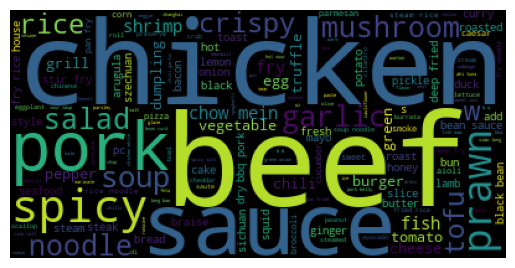

[('beef', 128), ('chicken', 126), ('sauce', 96), ('pork', 63), ('spicy', 56), ('prawn', 45), ('garlic', 44), ('soup', 43), ('mushroom', 43), ('noodle', 42)]


In [27]:
# make wordcloud across all restaurant types
word_counter = dict()

word_counter["all"] = make_word_cloud()
print(word_counter["all"][:10]) # print top 10 words

Text counts =  592


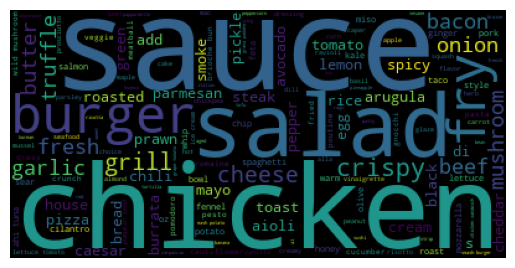

[('sauce', 42), ('chicken', 37), ('salad', 34), ('burger', 32), ('fry', 32), ('crispy', 32), ('grill', 29), ('cheese', 27), ('garlic', 25), ('mushroom', 24)]


In [28]:
# make wordcloud for Western restaurant
word_counter["en"] = make_word_cloud(restaurant_type="en")
print(word_counter["en"][:10]) # print top 10 words

Text counts =  792


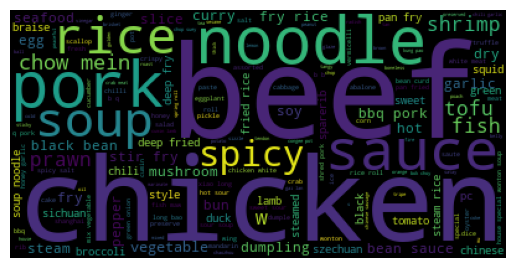

[('beef', 111), ('chicken', 104), ('noodle', 66), ('pork', 64), ('sauce', 54), ('rice', 41), ('soup', 39), ('spicy', 38), ('chow mein', 37), ('tofu', 34)]


In [29]:
# make wordcloud for Chinese restaurant
word_counter["ch"] = make_word_cloud(restaurant_type="ch")
print(word_counter["ch"][:10]) # print top 10 words

In [30]:
# make wordcloud for Chinese restaurant
word_counter["ch_tokenized"] = make_word_cloud(restaurant_type="ch", show_image=False, text_col="tokens_ch")
print(word_counter["ch_tokenized"][:10]) # print top 10 words

Text counts =  792
[('炒面', 10), ('叉', 8), ('雞', 8), ('牛肉', 8), ('飯', 7), ('炒', 6), ('雞瀨粉', 6), ('燒肉', 4), ('咖喱', 4), ('上海', 4)]


## N-grams

In [31]:
from collections import Counter

def count_ngrams(df=vocab_df, restaurant_type=None, text_col="tokens_en", n=2, min_freq=2):
    
    def generate_ngrams(tokens, n):
        """Generate n-grams from a list of cleaned tokens."""
        cleaned_tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]
        return [" ".join(cleaned_tokens[i:i+n]).strip() for i in range(len(cleaned_tokens)-n+1)]
    
    # Initialize a counter to hold all n-grams
    ngram_counter = Counter()

    # Process each specified column
    if restaurant_type is not None:
        df = df.query("restaurant_type_en_ch == @restaurant_type")

    for tokens_list in df[text_col]:
        # Skip if not a list
        if not isinstance(tokens_list, list):
            continue
        # Generate and update counts for bigrams and trigrams
        cleaned_tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens_list]
        ngrams = [" ".join(cleaned_tokens[i:i+n]).strip() for i in range(len(cleaned_tokens)-n+1)]
        ngram_counter.update(filter(None, ngrams))  # filter out empty strings

    # Filter n-grams by minimum frequency
    filtered_ngrams = [(ngram, count) for ngram, count in ngram_counter.items() if count >= min_freq and len(ngram.split()) == n]

    # Sort by frequency (descending) and n-gram length (ascending, to place bigrams before trigrams)
    sorted_ngrams = sorted(filtered_ngrams, key=lambda x: (-x[1], len(x[0].split())))

    return sorted_ngrams

In [53]:
unigrams = {}
unigrams['en'] = count_ngrams(restaurant_type='en', text_col="tokens_en", n=1)

In [54]:
unigrams['ch_en'] = count_ngrams(restaurant_type='ch', text_col="tokens_en", n=1)

In [55]:
unigrams['ch_ch'] = count_ngrams(restaurant_type='ch', text_col="tokens_ch", n=1)

In [56]:
unigrams['ch_ch']

[('炒面', 10),
 ('叉', 8),
 ('雞', 8),
 ('牛肉', 8),
 ('飯', 7),
 ('炒', 6),
 ('雞瀨粉', 6),
 ('燒肉', 4),
 ('咖喱', 4),
 ('上海', 4),
 ('豆腐', 4),
 ('什菜', 4),
 ('叉燒', 3),
 ('脆皮', 3),
 ('蜜汁', 3),
 ('雞飯', 3),
 ('肉', 3),
 ('白切', 3),
 ('貴妃', 3),
 ('四川', 3),
 ('椒', 3),
 ('孜然', 3),
 ('鹽', 3),
 ('燒燒', 2),
 ('雙拼', 2),
 ('燻', 2),
 ('蹄', 2),
 ('鴨翼', 2),
 ('燒飯', 2),
 ('金牌', 2),
 ('燒油', 2),
 ('走', 2),
 ('豉油', 2),
 ('地', 2),
 ('牛腩', 2),
 ('橙汁', 2),
 ('蠔油', 2),
 ('芥蘭', 2),
 ('生菜', 2),
 ('白飯', 2),
 ('和平', 2),
 ('炒飯', 2),
 ('干', 2),
 ('煸', 2),
 ('菜', 2),
 ('酸辣', 2),
 ('羹', 2),
 ('海鮮', 2),
 ('片', 2),
 ('北方', 2),
 ('貼', 2),
 ('羊', 2),
 ('排骨', 2),
 ('蔥', 2),
 ('爆', 2),
 ('雞丁', 2),
 ('辣子', 2),
 ('四季豆', 2),
 ('蒜蓉', 2),
 ('面', 2),
 ('麵', 2),
 ('孜', 2)]

In [32]:
bigrams = {}
bigrams['en'] = count_ngrams(restaurant_type='en', text_col="tokens_en", n=2, min_freq=5)
bigrams['en']

[('ahi tuna', 10),
 ('wild mushroom', 9),
 ('7 oz', 9),
 ('brioche bun', 9),
 ('ice cream', 8),
 ('smash burger', 7),
 ('with our', 7),
 ('mash potato', 7),
 ('chicken sandwich', 6),
 ('grape tomato', 6),
 ('pumpkin seed', 6),
 ('fry chicken', 6),
 ('grana padano', 6),
 ('chicken breast', 6),
 ('roasted garlic', 6),
 ('pork belly', 5),
 ('poach egg', 5),
 ('beet salad', 5),
 ('white wine', 5),
 ('house salad', 5),
 ('grill chicken', 5),
 ('only at', 5),
 ('super smash', 5),
 ('on a', 5),
 ('with a', 5),
 ('onion ring', 5),
 ('your choice', 5),
 ('choice of', 5),
 ('cream and', 5),
 ('oz cab', 5),
 ('crispy onion', 5)]

In [33]:
trigrams = {}
trigrams['en'] = count_ngrams(restaurant_type='en', text_col="tokens_en", n=3, min_freq=3)
trigrams['en']

[('super smash burger', 5),
 ('7 oz cab', 5),
 ('grill chicken breast', 4),
 ('available only at', 4),
 ('only at meet', 4),
 ('on a toast', 4),
 ('a toast potato', 4),
 ('toast potato bun', 4),
 ('crispy mash potato', 4),
 ('local wild mushroom', 4),
 ('mac n cheez', 3),
 ('a world of', 3),
 ('whip cream and', 3),
 ('jumbo lump crab', 3),
 ('lump crab cake', 3),
 ('truffle beurre blanc', 3),
 ('sear salmon sushi', 3),
 ('oz cab sirloin', 3),
 ('cab sirloin 425', 3),
 ('load crispy mash', 3),
 ('7 oz filet', 3),
 ('oz filet mignon', 3),
 ('mario s vanilla', 3),
 ('s vanilla bean', 3),
 ('vanilla bean gelato', 3),
 ('of your choice', 3)]

In [34]:
bigrams['ch'] = count_ngrams(restaurant_type='ch', text_col="tokens_en", n=2, min_freq=5)
bigrams['ch']

[('chow mein', 37),
 ('fry rice', 23),
 ('bean sauce', 23),
 ('black bean', 21),
 ('bbq pork', 19),
 ('deep fried', 16),
 ('steam rice', 14),
 ('rice noodle', 14),
 ('soup noodle', 14),
 ('with black', 14),
 ('beef with', 13),
 ('deep fry', 13),
 ('fry noodle', 12),
 ('pork with', 12),
 ('fried rice', 12),
 ('chicken white', 12),
 ('long bao', 11),
 ('on steam', 11),
 ('or chicken', 11),
 ('beef or', 11),
 ('bean curd', 10),
 ('spicy salt', 10),
 ('xiao long', 9),
 ('sour soup', 9),
 ('pan fry', 9),
 ('and sour', 9),
 ('rice roll', 9),
 ('fish maw', 9),
 ('stir fry', 9),
 ('chicken with', 9),
 ('green onion', 9),
 ('rice with', 9),
 ('white meat', 9),
 ('noodle soup', 8),
 ('sour pork', 8),
 ('soup with', 8),
 ('pork bun', 7),
 ('soy chicken', 7),
 ('mix vegetable', 7),
 ('curry chicken', 7),
 ('with dry', 7),
 ('in black', 7),
 ('pan fried', 7),
 ('honey garlic', 6),
 ('wonton soup', 6),
 ('cumin beef', 6),
 ('house special', 6),
 ('curry beef', 6),
 ('chicken chow', 6),
 ('shred pork

In [35]:
trigrams['ch'] = count_ngrams(restaurant_type='ch', text_col="tokens_en", n=3, min_freq=4)
trigrams['ch']

[('black bean sauce', 20),
 ('on steam rice', 11),
 ('with black bean', 11),
 ('beef or chicken', 10),
 ('xiao long bao', 9),
 ('chicken white meat', 9),
 ('chicken chow mein', 6),
 ('in black bean', 6),
 ('chicken or beef', 5),
 ('sweet and sour', 4),
 ('and sour pork', 4),
 ('pork fry rice', 4),
 ('with oyster sauce', 4),
 ('beef chow mein', 4),
 ('beef soup noodle', 4),
 ('with cashew nut', 4),
 ('hot and sour', 4),
 ('salt and pepper', 4),
 ('rice noodle with', 4),
 ('noodle with beef', 4),
 ('bean curd with', 4),
 ('pan fried rice', 4)]

### Export word counters
Now we can define some functions to search for keyword, and how many times they mentioned in the dataset

In [36]:
# export data to a csv file
import csv

file_path = 'ngrams.csv'
with open(file_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Restaurant type', 'N-gram', 'Phrase', 'Count'])
    for restaurant_type, phrases in bigrams.items():
        for phrase, count in phrases:
            writer.writerow([restaurant_type, 'bigram', phrase, count])
    for restaurant_type, phrases in trigrams.items():
        for phrase, count in phrases:
            writer.writerow([restaurant_type, 'trigram', phrase, count])

In [59]:
file_path = 'unigrams.csv'
with open(file_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Restaurant type', 'Language', 'Phrase', 'Count'])
    for restaurant_type, phrases in unigrams.items():
        if restaurant_type == 'en': 
            for phrase, count in phrases:
                writer.writerow(['Western', 'English', phrase, count])
        if restaurant_type == 'ch_en': 
            for phrase, count in phrases:
                writer.writerow(['Chinese', 'English', phrase, count])
        if restaurant_type == 'ch_ch': 
            for phrase, count in phrases:
                writer.writerow(['Chinese', 'Chinese', phrase, count])

In [57]:
for restaurant_type, phrases in unigrams.items():
    print(restaurant_type)

en
ch_en
ch_ch


### Keyword search 
Now we can define some functions to search for keyword, and how many times they mentioned in the dataset

In [37]:
def get_mention_count(keyword, df=vocab_df, restaurant_type=None, search_col="text"):
    """
        Count how many times a keyword (dish) was mentioned in the dataset
        Input:
            df: the dataframe to search on
            keyword: the keyword to search for
            restaurent_type: "ch" (Chinese) or "en" (Western). None to search in both categories
            search_col: the column name to search. Default "text"
        Return:
            number of mentions in dataset
            
    """
    result = 0
    kw = keyword.lower() 
    if restaurant_type is not None:
        result = df.query("restaurant_type_en_ch == @restaurant_type")[search_col].str.contains(kw)
    else:
        result = df[search_col].str.contains(kw)
    
    # return len(result)
    return sum(result)

get_mention_count('burger')

38

In [38]:
keyword = 'burger'
kw_count = get_mention_count(keyword)
print(f"The dish [{keyword}] are mentioned [{kw_count}] times in all the dataset")

kw_count = get_mention_count(keyword, restaurant_type="en")
print(f"[{keyword}] mentioned [{kw_count}] times in the Western restaurants")

kw_count = get_mention_count(keyword, restaurant_type="ch")
print(f"[{keyword}] mentioned [{kw_count}] times in the Chinese restaurants")

The dish [burger] are mentioned [38] times in all the dataset
[burger] mentioned [38] times in the Western restaurants
[burger] mentioned [0] times in the Chinese restaurants


In [39]:
keyword = 'soup'
kw_count = get_mention_count(keyword)
print(f"The dish [{keyword}] are mentioned [{kw_count}] times in all the dataset")

kw_count = get_mention_count(keyword, restaurant_type="en")
print(f"[{keyword}] mentioned [{kw_count}] times in the Western restaurants")

kw_count = get_mention_count(keyword, restaurant_type="ch")
print(f"[{keyword}] mentioned [{kw_count}] times in the Chinese restaurants")

The dish [soup] are mentioned [72] times in all the dataset
[soup] mentioned [4] times in the Western restaurants
[soup] mentioned [68] times in the Chinese restaurants


In [40]:
keyword = 'noodle'
kw_count = get_mention_count(keyword)
print(f"The dish [{keyword}] are mentioned [{kw_count}] times in all the dataset")

kw_count = get_mention_count(keyword, restaurant_type="en")
print(f"[{keyword}] mentioned [{kw_count}] times in the Western restaurants")

kw_count = get_mention_count(keyword, restaurant_type="ch")
print(f"[{keyword}] mentioned [{kw_count}] times in the Chinese restaurants")

The dish [noodle] are mentioned [81] times in all the dataset
[noodle] mentioned [3] times in the Western restaurants
[noodle] mentioned [78] times in the Chinese restaurants


In [41]:
# search for Chinese dish in 'ch_counterpart_if_any' column

keyword = u'雞飯' # "chicken rice"
kw_count = get_mention_count(keyword, search_col='ch_counterpart_if_any')
print(f"The dish [{keyword}] are mentioned [{kw_count}] times in all the dataset")

kw_count = get_mention_count(keyword, restaurant_type="en", search_col='ch_counterpart_if_any')
print(f"[{keyword}] mentioned [{kw_count}] times in the Western restaurants")

kw_count = get_mention_count(keyword, restaurant_type="ch",  search_col='ch_counterpart_if_any')
print(f"[{keyword}] mentioned [{kw_count}] times in the Chinese restaurants")

The dish [雞飯] are mentioned [5] times in all the dataset
[雞飯] mentioned [0] times in the Western restaurants
[雞飯] mentioned [5] times in the Chinese restaurants


In [42]:
# Load the CSV file
df_vocab = pd.read_csv('/Users/SFL/Documents/GitHub/Codeswitching-Project/data/output/tokenized_food_vocab_2.csv')

# Assuming there's a single column with words, named 'word' for this example
# Update 'word' to match your actual column name
words_with_punctuation = df_vocab[df_vocab['word_dish'].apply(lambda x: bool(re.search(r"\w+['.]\w+", x)))]

# This gives you a filtered DataFrame with only the words containing punctuation
print(words_with_punctuation)

                                              word_dish lang_en_ch   
107                       Lettuce w.Fermented Bean Curd    en + ch  \
188                              General Tsao's Chicken         en   
261             Bird's Nest with Crab Meat and Fish Maw         en   
370        Napa Cabbage in Broth w.Fish Maw & Fish Tofu         en   
469                              General Tsao's Chicken         en   
506                                Xi'an Cold Noodles l         en   
513                                B.B.Q.Pork Chop Suey         en   
515                 B.B.Q. Pork or Chicken Egg Foo Yong         en   
533                          Bean Curd with B.B.Q. Pork         en   
542                              B.B.Q. Pork Fried Rice         en   
545                     Shrimp & B.B.Q. Pork Fried Rice         en   
558                                B.B.Q.Pork Chow Mein         en   
578                           B.B.Q. Pork with Broccoli         en   
604                 